# Detection of Alzheimer's Disease Using Graph Signal Processing of EEG Recordings


## Data

Link here: https://openneuro.org/datasets/ds004504/versions/1.0.6

### Participants:
- **Total subjects: 88**
  - **Alzheimer's disease (AD group): 36**
    - Average MMSE: 17.75 (sd=4.5)
    - Mean age: 66.4 (sd=7.9)
    - Median disease duration: 25 months, IQR: 24 - 28.5
  - **Frontotemporal Dementia (FTD group): 23**
    - Average MMSE: 22.17 (sd=8.22)
    - Mean age: 63.6 (sd=8.2)
  - **Healthy subjects (CN group): 29**
    - Average MMSE: 30
    - Mean age: 67.9 (sd=5.4)
- **MMSE score ranges:** 0 to 30 (lower scores indicate more severe decline)

### Recordings:
- **Location:** 2nd Department of Neurology of AHEPA General Hospital, Thessaloniki
- **Device:** Nihon Kohden EEG 2100 clinical device, 19 scalp electrodes, 2 reference electrodes
- **Parameters:** 500 Hz sampling rate, 10uV/mm resolution, sensitivity 10uV/mm, time constant 0.3s, high-frequency filter at 70 Hz
- **Duration:** 
  - AD group: 13.5 minutes (min=5.1, max=21.3)
  - FTD group: 12 minutes (min=7.9, max=16.9)
  - CN group: 13.8 minutes (min=12.5, max=16.5)
- **Total recordings:**
  - AD: 485.5 minutes
  - FTD: 276.5 minutes
  - CN: 402 minutes

### Preprocessing:
- **Exported to:** .eeg format, transformed to BIDS accepted .set format
- **Unprocessed recordings in folders named:** sub-0XX
- **Preprocessed and denoised recordings in sub-0XX within subfolder derivatives**
- **Preprocessing pipeline:**
  - Butterworth band-pass filter 0.5-45 Hz
  - Re-referenced to A1-A2
  - Artifact Subspace Reconstruction (ASR) applied
  - Independent Component Analysis (ICA) method performed, transformed to 19 ICA components
  - Eye and jaw artifacts automatically rejected
- **Automatic annotations of artifacts not included for language compatibility**
- **Preprocessed dataset available in Folder:** derivatives

## Methodology

Same as in [Detection of Epilepsy Using Graph Signal Processing of EEG Signals with Three Features](https://link.springer.com/chapter/10.1007/978-981-19-1520-8_46)


## GSP Processing

In [1]:
import pandas as pd
import numpy as np
import mne
import os
from pygsp import graphs, utils
from scipy.spatial import distance_matrix
from scipy.stats import entropy
import networkx as nx
from sklearn.cluster import spectral_clustering

In [ ]:
def compute_total_variation(W, data_values):
    N = data_values.shape[0]
    TV = 0
    for i in range(N):
        for j in range(N):
            wij = W[i, j]
            difference = data_values[j] - data_values[i]
            TV += wij * np.linalg.norm(difference)**2
    return np.sqrt(TV)

dir_path = r'C:\Users\xmoot\Desktop\VSCode\gsp-eeg-alz\features_tv.csv'
file_list = [entry.path for entry in os.scandir(dir_path) if entry.is_file() and entry.path.endswith(".set")]

n_files = len(file_list)
if n_files == 0:
    raise ValueError(f"No .set files found in directory {dir_path}.")

print(f'Found {n_files} .set files.')

channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']

data_list = []
features = {}

for i, file in enumerate(file_list):
    raw = mne.io.read_raw_eeglab(file)
    data = raw.get_data(picks=channel_names)
    transposed_data = np.transpose(data)
    data = pd.DataFrame(transposed_data, columns=channel_names)
    data = data.groupby(data.index // 50).median()
    data_list.append(data)

    # GSP analysis
    distances = distance_matrix(data.values, data.values)
    theta, k = 1.0, 1.0 
    W = np.exp(-distances**2 / theta**2)
    W[distances > k] = 0
    np.fill_diagonal(W, 0)
    G = graphs.Graph(W)
    L = G.L.toarray()
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    X_GdataT = eigenvectors.T @ data.values
    C = np.cov(X_GdataT)
    T = eigenvectors.T.conj() @ C @ eigenvectors
    r = np.linalg.norm(np.diag(T)) / np.linalg.norm(T, 'fro')
    P = L @ data.values
    Y = np.sum(data.values * P)**2
    TV = compute_total_variation(W, data.values)

    # Spectral Graph Features
    graph_energy = np.sum(np.abs(eigenvalues))
    spectral_entropy = entropy(np.square(eigenvectors))

    # Graph Signal Features
    signal_energy = np.sum(np.square(data.values))
    signal_power = np.var(data.values)

    # Graph Modularity and Community Structure
    labels = spectral_clustering(W)
    unique_labels = len(np.unique(labels))

    # Graph Degree Distribution
    degree_distribution = np.sum(W, axis=0)

    # Graph Diffusion Characteristics
    heat_trace = np.trace(np.exp(-L))
    diffusion_distance = np.sum(np.exp(-L))

    # Aggregating Features
    features[os.path.basename(file)] = {
        'stationary_ratio': r, 
        'Tik-norm': Y, 
        'Total_Variation': TV,
        'graph_energy': graph_energy,
        'spectral_entropy': spectral_entropy,
        'signal_energy': signal_energy,
        'signal_power': signal_power,
        'unique_clusters': unique_labels,
        'avg_degree': np.mean(degree_distribution),
        'heat_trace': heat_trace,
        'diffusion_distance': diffusion_distance
    }

features_data = pd.DataFrame(features).T
features_data.to_csv('features_tv.csv', index_label='participant_id')

## Processing 

In [3]:
import pandas as pd
import numpy as np

features = pd.read_csv("features_tv.csv", )
participants = pd.read_csv("./ds004504/participants.tsv", delimiter='\t')
data = features.merge(participants, left_index=True, right_index=True)
data

,participant_id_x,stationary_ratio,Tik-norm,Total_Variation,graph_energy,spectral_entropy,signal_energy,signal_power,unique_clusters,avg_degree,heat_trace,diffusion_distance,participant_id_y,Gender,Age,Group,MMSE
0,sub-011_task-eyesclosed_eeg.set,0.065765,1.472647,1.557900,5.928230e+07,8.948846,0.000158,1.077305e-09,8.0,7698.999685,0.0,1.611460e+08,sub-001,F,57,A,16
1,sub-088_task-eyesclosed_eeg.set,0.037262,1.189033,1.476772,6.156756e+07,8.967759,0.000139,9.320460e-10,8.0,7845.999722,0.0,1.673580e+08,sub-002,F,78,A,22
2,sub-045_task-eyesclosed_eeg.set,0.063532,2.015106,1.684959,7.253077e+07,9.049702,0.000167,1.029976e-09,8.0,8515.999667,0.0,1.971591e+08,sub-003,M,70,A,14
3,sub-038_task-eyesclosed_eeg.set,0.057751,1.793222,1.636528,7.945048e+07,9.095266,0.000150,8.870028e-10,8.0,8912.999700,0.0,2.159688e+08,sub-004,F,67,A,20
4,sub-002_task-eyesclosed_eeg.set,0.036089,1.152527,1.465304,6.289283e+07,8.978408,0.000135,8.982981e-10,8.0,7929.999729,0.0,1.709604e+08,sub-005,M,70,A,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,sub-015_task-eyesclosed_eeg.set,0.044033,2.469593,1.772847,8.124318e+07,9.106423,0.000174,1.017948e-09,8.0,9012.999651,0.0,2.208419e+08,sub-084,F,71,F,24
84,sub-027_task-eyesclosed_eeg.set,0.031677,2.338241,1.748789,6.825238e+07,9.019301,0.000185,1.179025e-09,8.0,8260.999630,0.0,1.855292e+08,sub-085,M,64,F,26
85,sub-003_task-eyesclosed_eeg.set,0.048940,0.017792,0.516504,9.366660e+06,8.026170,0.000044,7.492876e-10,8.0,3059.999913,0.0,2.546122e+07,sub-086,M,49,F,26
86,sub-057_task-eyesclosed_eeg.set,0.031148,1.485881,1.561389,6.343326e+07,8.982687,0.000153,1.011276e-09,8.0,7963.999694,0.0,1.724295e+08,sub-087,M,73,F,24


## Multi-Classification

In [4]:
features = {
    'stationary_ratio': 'Stationary Ratio',
    'Tik-norm': 'Tik-norm',
    'Total_Variation': 'Total Variation',
    'graph_energy': 'Graph Energy',
    'spectral_entropy': 'Spectral Entropy',
    'signal_energy': 'Signal Energy',
    'signal_power': 'Signal Power',
    'avg_degree': 'Average Degree',
    'diffusion_distance': 'Diffusion Distance',
}

### Random Forest

Validation ROC AUC for class A (Class 0): 0.41363636363636364
Test ROC AUC for class A (Class 0): 0.6098901098901099
Validation ROC AUC for class C (Class 1): 0.420940170940171
Test ROC AUC for class C (Class 1): 0.31521739130434784
Validation ROC AUC for class F (Class 2): 0.4166666666666666
Test ROC AUC for class F (Class 2): 0.6911764705882353

Validation Precision, Recall, F1-score:
               precision    recall  f1-score   support

           A       0.18      0.18      0.18        11
           C       0.36      0.38      0.37        13
           F       0.33      0.29      0.31         7

    accuracy                           0.29        31
   macro avg       0.29      0.28      0.29        31
weighted avg       0.29      0.29      0.29        31


Test Precision, Recall, F1-score:
               precision    recall  f1-score   support

           A       0.58      0.54      0.56        13
           C       0.09      0.25      0.13         4
           F       0.50      

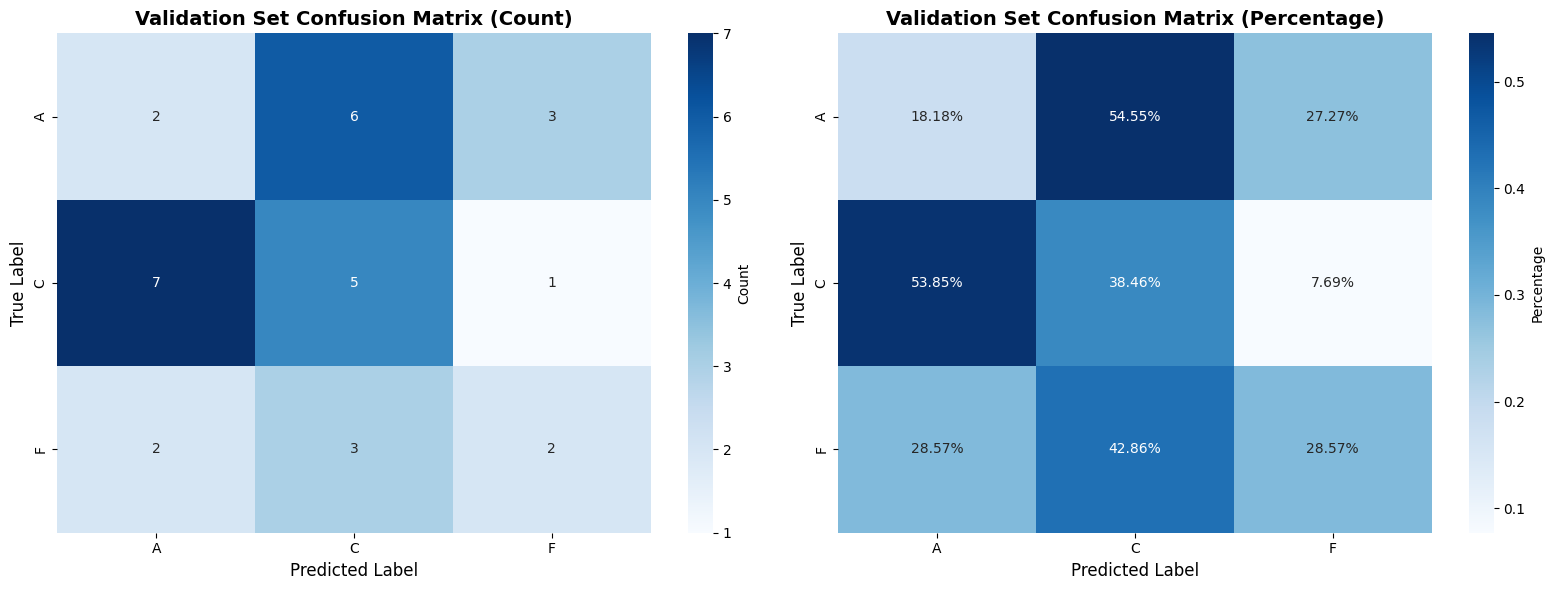

✓ 測試集混淆矩陣已保存到: ./baseline_results/random_forest/confusion_matrix_test.png


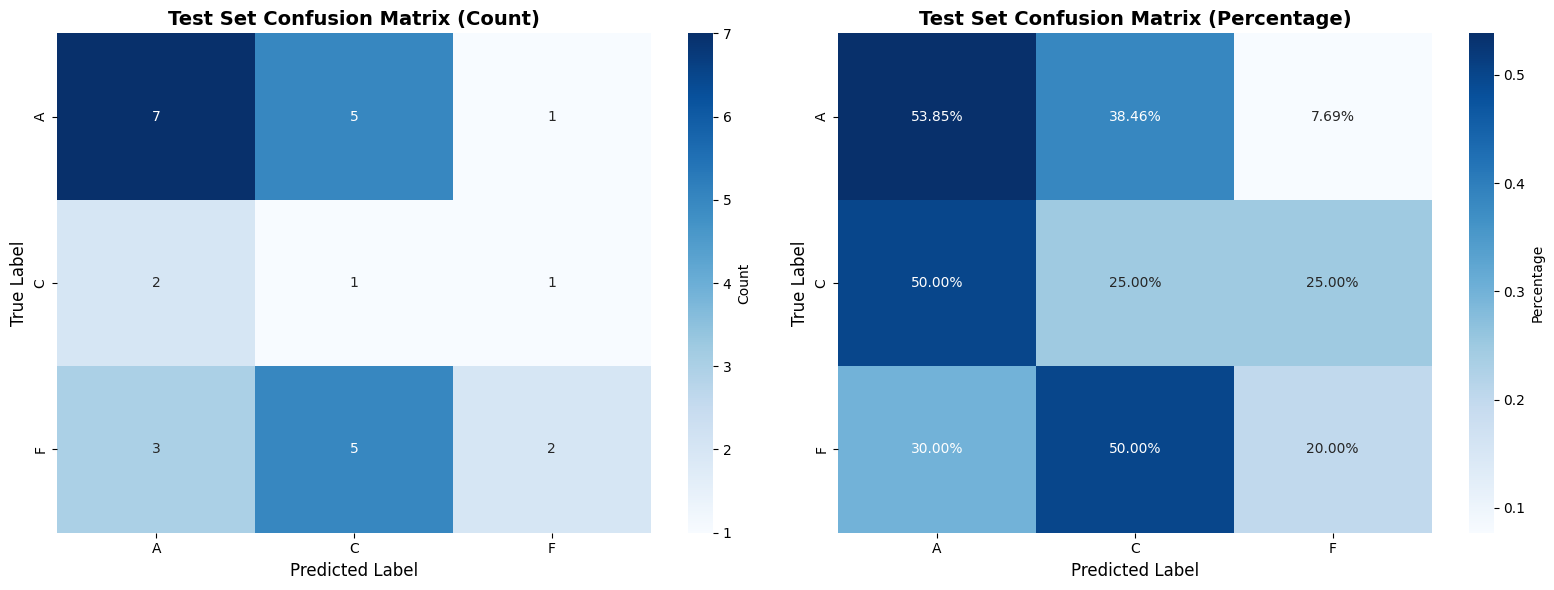

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# The features are 'stationary_ratio' and 'Tik_norm'
X = data[list(features.keys())]

# The target is 'Group'
y = data['Group']

# Split the data into train+validation set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the train data into train set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_val_int = le.transform(y_val)
y_test_int = le.transform(y_test)

# Hyperparameters
params = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

clf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(clf, params, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_int)

best_clf = grid_search.best_estimator_

# Validate and test metrics
for label, group_name in enumerate(le.classes_):
    y_val_label = (y_val_int == label).astype(int)
    y_test_label = (y_test_int == label).astype(int)
    y_val_pred_prob = best_clf.predict_proba(X_val_scaled)[:, label]
    y_test_pred_prob = best_clf.predict_proba(X_test_scaled)[:, label]

    fpr_val, tpr_val, _ = roc_curve(y_val_label, y_val_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test_label, y_test_pred_prob)

    print(f"Validation ROC AUC for class {group_name} (Class {label}): {auc(fpr_val, tpr_val)}")
    print(f"Test ROC AUC for class {group_name} (Class {label}): {auc(fpr_test, tpr_test)}")

y_val_pred = le.inverse_transform(best_clf.predict(X_val_scaled))
y_test_pred = le.inverse_transform(best_clf.predict(X_test_scaled))

print("\nValidation Precision, Recall, F1-score:\n", classification_report(y_val, y_val_pred))
print("\nTest Precision, Recall, F1-score:\n", classification_report(y_test, y_test_pred))

# 繪製 Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score
from datetime import datetime

# 創建結果目錄
results_dir = './baseline_results/random_forest'
os.makedirs(results_dir, exist_ok=True)

# 計算評估指標
y_val_pred_int = best_clf.predict(X_val_scaled)
y_test_pred_int = best_clf.predict(X_test_scaled)
y_val_pred_proba = best_clf.predict_proba(X_val_scaled)
y_test_pred_proba = best_clf.predict_proba(X_test_scaled)

val_balanced_acc = balanced_accuracy_score(y_val_int, y_val_pred_int)
test_balanced_acc = balanced_accuracy_score(y_test_int, y_test_pred_int)

macro_roc_auc_val = roc_auc_score(y_val_int, y_val_pred_proba, multi_class='ovr', average='macro')
weighted_roc_auc_val = roc_auc_score(y_val_int, y_val_pred_proba, multi_class='ovr', average='weighted')
macro_roc_auc_test = roc_auc_score(y_test_int, y_test_pred_proba, multi_class='ovr', average='macro')
weighted_roc_auc_test = roc_auc_score(y_test_int, y_test_pred_proba, multi_class='ovr', average='weighted')

overfitting_gap = val_balanced_acc - test_balanced_acc

# 保存評估指標到文本文件
with open(os.path.join(results_dir, 'evaluation_metrics.txt'), 'w', encoding='utf-8') as f:
    f.write("="*60 + "\n")
    f.write("多分類評估結果\n")
    f.write("="*60 + "\n")
    f.write(f"生成時間: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("驗證集結果:\n")
    f.write("-"*60 + "\n")
    f.write(f"Balanced Accuracy: {val_balanced_acc:.4f}\n")
    f.write(f"宏平均 ROC AUC: {macro_roc_auc_val:.4f}\n")
    f.write(f"加權平均 ROC AUC: {weighted_roc_auc_val:.4f}\n\n")
    f.write("混淆矩陣:\n")
    f.write(str(confusion_matrix(y_val_int, y_val_pred_int)) + "\n\n")
    f.write("分類報告:\n")
    f.write(classification_report(y_val_int, y_val_pred_int, 
                                target_names=list(le.classes_)) + "\n")
    
    f.write("\n" + "="*60 + "\n")
    f.write("測試集結果:\n")
    f.write("-"*60 + "\n")
    f.write(f"Balanced Accuracy: {test_balanced_acc:.4f}\n")
    f.write(f"宏平均 ROC AUC: {macro_roc_auc_test:.4f}\n")
    f.write(f"加權平均 ROC AUC: {weighted_roc_auc_test:.4f}\n\n")
    f.write("混淆矩陣:\n")
    f.write(str(confusion_matrix(y_test_int, y_test_pred_int)) + "\n\n")
    f.write("分類報告:\n")
    f.write(classification_report(y_test_int, y_test_pred_int,
                                target_names=list(le.classes_)) + "\n")
    
    f.write("\n" + "="*60 + "\n")
    f.write("過擬合分析:\n")
    f.write("-"*60 + "\n")
    f.write(f"驗證集 Balanced Accuracy: {val_balanced_acc:.4f}\n")
    f.write(f"測試集 Balanced Accuracy: {test_balanced_acc:.4f}\n")
    f.write(f"過擬合差距: {overfitting_gap:.4f}\n")

print(f"✓ 評估指標已保存到: {os.path.join(results_dir, 'evaluation_metrics.txt')}")

class_names = list(le.classes_)

# 驗證集 Confusion Matrix
cm_val = confusion_matrix(y_val_int, y_val_pred_int)
cm_val_normalized = cm_val.astype('float') / (cm_val.sum(axis=1)[:, np.newaxis] + 1e-10)
cm_val_normalized = np.nan_to_num(cm_val_normalized)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 原始混淆矩陣
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names,
           ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Validation Set Confusion Matrix (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# 歸一化混淆矩陣
sns.heatmap(cm_val_normalized, annot=True, fmt='.2%', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names,
           ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Validation Set Confusion Matrix (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
val_cm_path = os.path.join(results_dir, 'confusion_matrix_validation.png')
plt.savefig(val_cm_path, dpi=300, bbox_inches='tight')
print(f"✓ 驗證集混淆矩陣已保存到: {val_cm_path}")
plt.show()
plt.close()

# 測試集 Confusion Matrix
cm_test = confusion_matrix(y_test_int, y_test_pred_int)
cm_test_normalized = cm_test.astype('float') / (cm_test.sum(axis=1)[:, np.newaxis] + 1e-10)
cm_test_normalized = np.nan_to_num(cm_test_normalized)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 原始混淆矩陣
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names,
           ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Test Set Confusion Matrix (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# 歸一化混淆矩陣
sns.heatmap(cm_test_normalized, annot=True, fmt='.2%', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names,
           ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Test Set Confusion Matrix (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
test_cm_path = os.path.join(results_dir, 'confusion_matrix_test.png')
plt.savefig(test_cm_path, dpi=300, bbox_inches='tight')
print(f"✓ 測試集混淆矩陣已保存到: {test_cm_path}")
plt.show()
plt.close()


### Logistic Regression

Validation ROC AUC for class A (Class 0): 0.29545454545454547
Test ROC AUC for class A (Class 0): 0.5274725274725275
Validation ROC AUC for class C (Class 1): 0.37179487179487186
Test ROC AUC for class C (Class 1): 0.5108695652173914
Validation ROC AUC for class F (Class 2): 0.43452380952380953
Test ROC AUC for class F (Class 2): 0.5235294117647059

Validation Precision, Recall, F1-score:
               precision    recall  f1-score   support

           A       0.20      0.27      0.23        11
           C       0.30      0.23      0.26        13
           F       0.17      0.14      0.15         7

    accuracy                           0.23        31
   macro avg       0.22      0.22      0.22        31
weighted avg       0.23      0.23      0.23        31


Test Precision, Recall, F1-score:
               precision    recall  f1-score   support

           A       0.45      0.38      0.42        13
           C       0.27      0.75      0.40         4
           F       0.60    

/home/b12901075/miniconda3/envs/bci_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/b12901075/miniconda3/envs/bci_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/b12901075/miniconda3/envs/bci_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(


✓ 驗證集混淆矩陣已保存到: ./baseline_results/logistic_regression/confusion_matrix_validation.png


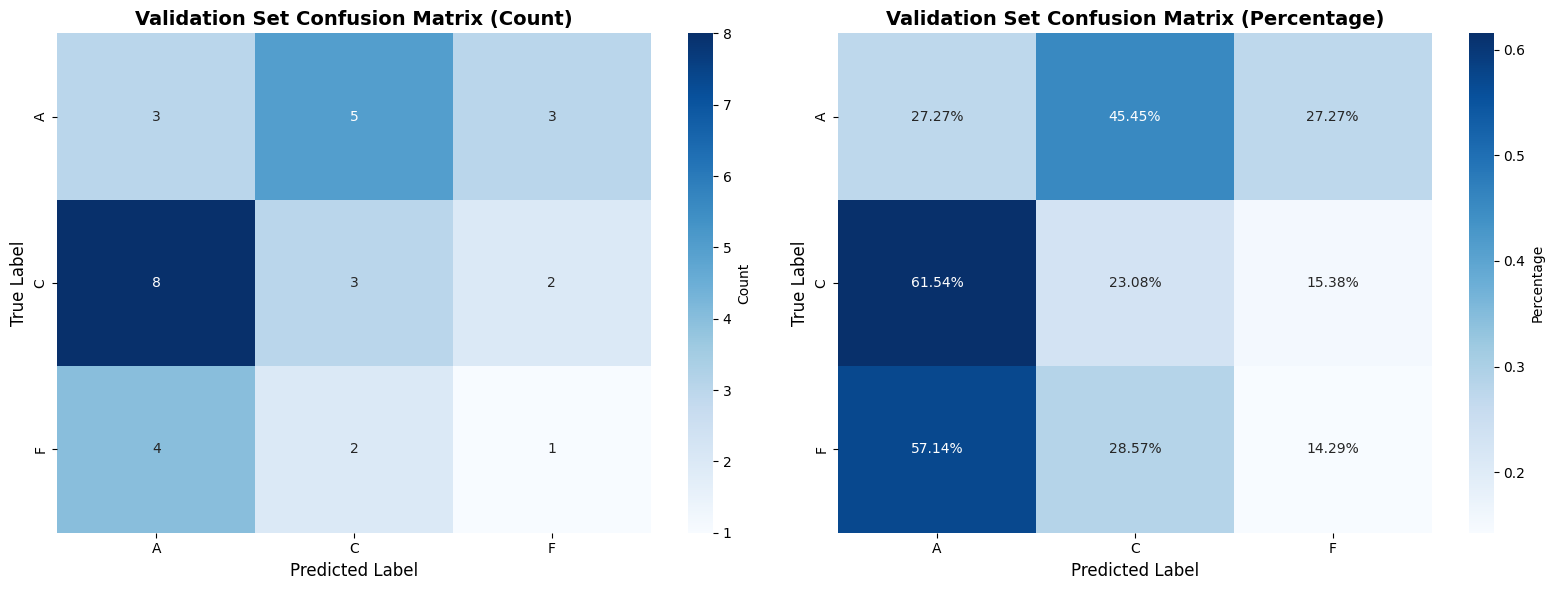

✓ 測試集混淆矩陣已保存到: ./baseline_results/logistic_regression/confusion_matrix_test.png


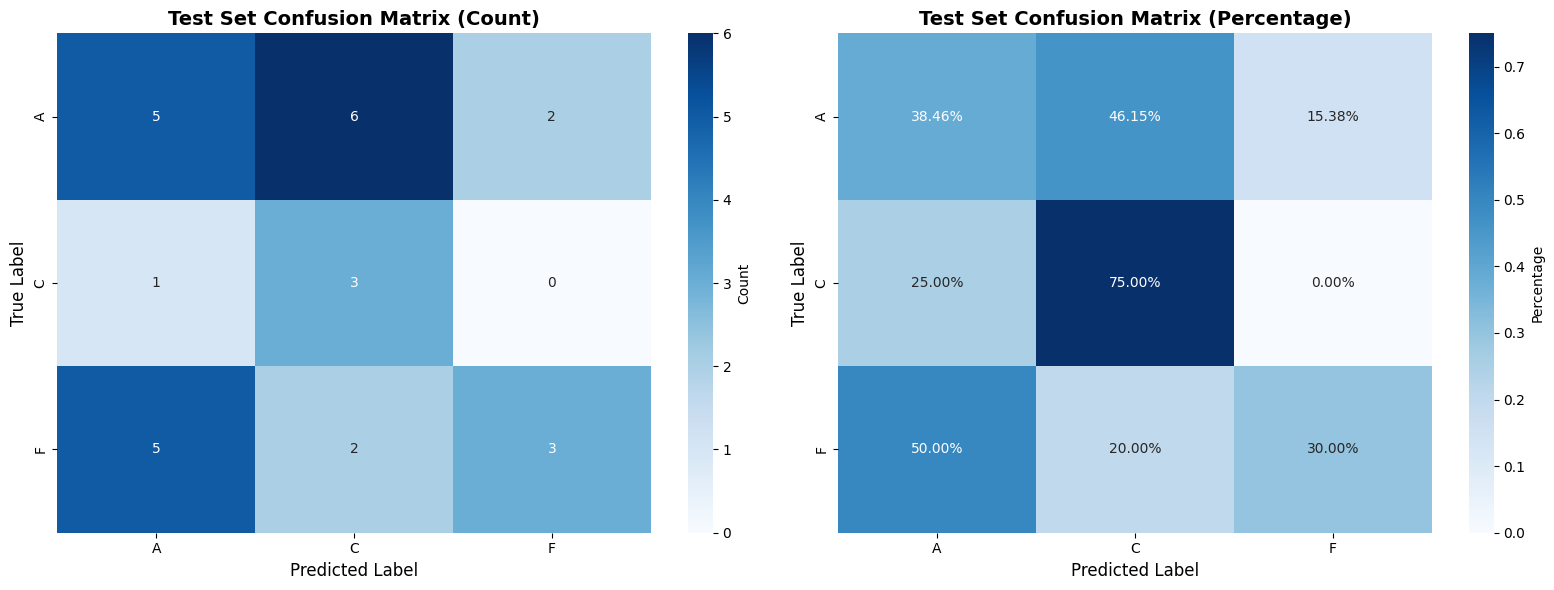

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

# The features are 'stationary_ratio' and 'Tik-norm'
X = data[list(features.keys())]

# The target is 'Group'
y = data['Group']

# Split the data into train+validation set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the train data into train set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_val_int = le.transform(y_val)
y_test_int = le.transform(y_test)

clf = LogisticRegression(random_state=42, multi_class='auto', solver='liblinear', n_jobs=-1)
clf.fit(X_train_scaled, y_train_int)

# Validate and test metrics
for label, group_name in enumerate(le.classes_):
    y_val_label = (y_val_int == label).astype(int)
    y_test_label = (y_test_int == label).astype(int)
    y_val_pred_prob = clf.predict_proba(X_val_scaled)[:, label]
    y_test_pred_prob = clf.predict_proba(X_test_scaled)[:, label]

    fpr_val, tpr_val, _ = roc_curve(y_val_label, y_val_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test_label, y_test_pred_prob)

    print(f"Validation ROC AUC for class {group_name} (Class {label}): {auc(fpr_val, tpr_val)}")
    print(f"Test ROC AUC for class {group_name} (Class {label}): {auc(fpr_test, tpr_test)}")

y_val_pred = le.inverse_transform(clf.predict(X_val_scaled))
y_test_pred = le.inverse_transform(clf.predict(X_test_scaled))

print("\nValidation Precision, Recall, F1-score:\n", classification_report(y_val, y_val_pred))
print("\nTest Precision, Recall, F1-score:\n", classification_report(y_test, y_test_pred))

# 繪製 Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score
from datetime import datetime

# 創建結果目錄
results_dir = './baseline_results/logistic_regression'
os.makedirs(results_dir, exist_ok=True)

# 計算評估指標
y_val_pred_int = clf.predict(X_val_scaled)
y_test_pred_int = clf.predict(X_test_scaled)
y_val_pred_proba = clf.predict_proba(X_val_scaled)
y_test_pred_proba = clf.predict_proba(X_test_scaled)

val_balanced_acc = balanced_accuracy_score(y_val_int, y_val_pred_int)
test_balanced_acc = balanced_accuracy_score(y_test_int, y_test_pred_int)

macro_roc_auc_val = roc_auc_score(y_val_int, y_val_pred_proba, multi_class='ovr', average='macro')
weighted_roc_auc_val = roc_auc_score(y_val_int, y_val_pred_proba, multi_class='ovr', average='weighted')
macro_roc_auc_test = roc_auc_score(y_test_int, y_test_pred_proba, multi_class='ovr', average='macro')
weighted_roc_auc_test = roc_auc_score(y_test_int, y_test_pred_proba, multi_class='ovr', average='weighted')

overfitting_gap = val_balanced_acc - test_balanced_acc

# 保存評估指標到文本文件
with open(os.path.join(results_dir, 'evaluation_metrics.txt'), 'w', encoding='utf-8') as f:
    f.write("="*60 + "\n")
    f.write("多分類評估結果\n")
    f.write("="*60 + "\n")
    f.write(f"生成時間: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("驗證集結果:\n")
    f.write("-"*60 + "\n")
    f.write(f"Balanced Accuracy: {val_balanced_acc:.4f}\n")
    f.write(f"宏平均 ROC AUC: {macro_roc_auc_val:.4f}\n")
    f.write(f"加權平均 ROC AUC: {weighted_roc_auc_val:.4f}\n\n")
    f.write("混淆矩陣:\n")
    f.write(str(confusion_matrix(y_val_int, y_val_pred_int)) + "\n\n")
    f.write("分類報告:\n")
    f.write(classification_report(y_val_int, y_val_pred_int, 
                                target_names=list(le.classes_)) + "\n")
    
    f.write("\n" + "="*60 + "\n")
    f.write("測試集結果:\n")
    f.write("-"*60 + "\n")
    f.write(f"Balanced Accuracy: {test_balanced_acc:.4f}\n")
    f.write(f"宏平均 ROC AUC: {macro_roc_auc_test:.4f}\n")
    f.write(f"加權平均 ROC AUC: {weighted_roc_auc_test:.4f}\n\n")
    f.write("混淆矩陣:\n")
    f.write(str(confusion_matrix(y_test_int, y_test_pred_int)) + "\n\n")
    f.write("分類報告:\n")
    f.write(classification_report(y_test_int, y_test_pred_int,
                                target_names=list(le.classes_)) + "\n")
    
    f.write("\n" + "="*60 + "\n")
    f.write("過擬合分析:\n")
    f.write("-"*60 + "\n")
    f.write(f"驗證集 Balanced Accuracy: {val_balanced_acc:.4f}\n")
    f.write(f"測試集 Balanced Accuracy: {test_balanced_acc:.4f}\n")
    f.write(f"過擬合差距: {overfitting_gap:.4f}\n")

print(f"✓ 評估指標已保存到: {os.path.join(results_dir, 'evaluation_metrics.txt')}")

class_names = list(le.classes_)

# 驗證集 Confusion Matrix
cm_val = confusion_matrix(y_val_int, y_val_pred_int)
cm_val_normalized = cm_val.astype('float') / (cm_val.sum(axis=1)[:, np.newaxis] + 1e-10)
cm_val_normalized = np.nan_to_num(cm_val_normalized)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 原始混淆矩陣
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names,
           ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Validation Set Confusion Matrix (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# 歸一化混淆矩陣
sns.heatmap(cm_val_normalized, annot=True, fmt='.2%', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names,
           ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Validation Set Confusion Matrix (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
val_cm_path = os.path.join(results_dir, 'confusion_matrix_validation.png')
plt.savefig(val_cm_path, dpi=300, bbox_inches='tight')
print(f"✓ 驗證集混淆矩陣已保存到: {val_cm_path}")
plt.show()
plt.close()

# 測試集 Confusion Matrix
cm_test = confusion_matrix(y_test_int, y_test_pred_int)
cm_test_normalized = cm_test.astype('float') / (cm_test.sum(axis=1)[:, np.newaxis] + 1e-10)
cm_test_normalized = np.nan_to_num(cm_test_normalized)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 原始混淆矩陣
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names,
           ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Test Set Confusion Matrix (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# 歸一化混淆矩陣
sns.heatmap(cm_test_normalized, annot=True, fmt='.2%', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names,
           ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Test Set Confusion Matrix (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
test_cm_path = os.path.join(results_dir, 'confusion_matrix_test.png')
plt.savefig(test_cm_path, dpi=300, bbox_inches='tight')
print(f"✓ 測試集混淆矩陣已保存到: {test_cm_path}")
plt.show()
plt.close()


### SVM

Validation ROC AUC for class A (Class 0): 0.7272727272727273
Test ROC AUC for class A (Class 0): 0.46153846153846156
Validation ROC AUC for class C (Class 1): 0.7222222222222223
Test ROC AUC for class C (Class 1): 0.3695652173913044
Validation ROC AUC for class F (Class 2): 0.3630952380952381
Test ROC AUC for class F (Class 2): 0.5823529411764706

Validation Precision, Recall, F1-score:
               precision    recall  f1-score   support

           A       0.23      0.27      0.25        11
           C       0.27      0.31      0.29        13
           F       0.00      0.00      0.00         7

    accuracy                           0.23        31
   macro avg       0.17      0.19      0.18        31
weighted avg       0.19      0.23      0.21        31


Test Precision, Recall, F1-score:
               precision    recall  f1-score   support

           A       0.45      0.38      0.42        13
           C       0.21      0.75      0.33         4
           F       0.50      

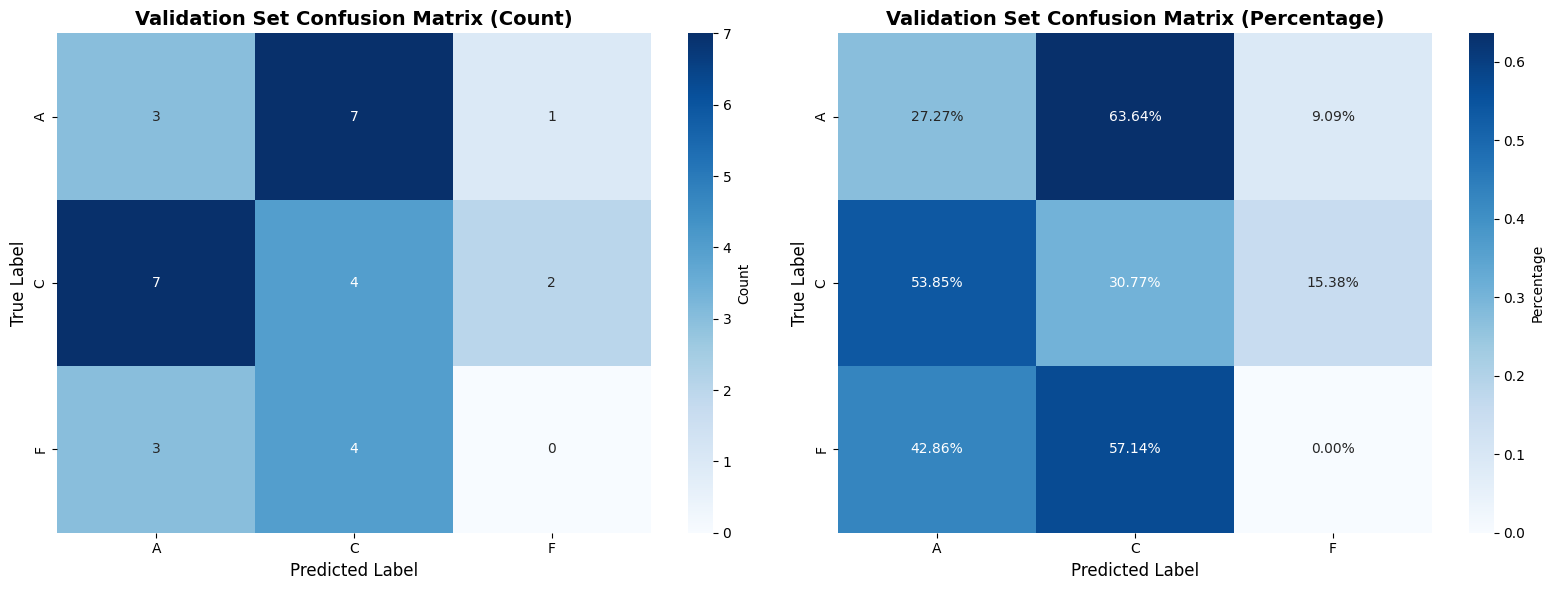

✓ 測試集混淆矩陣已保存到: ./baseline_results/SVM/confusion_matrix_test.png


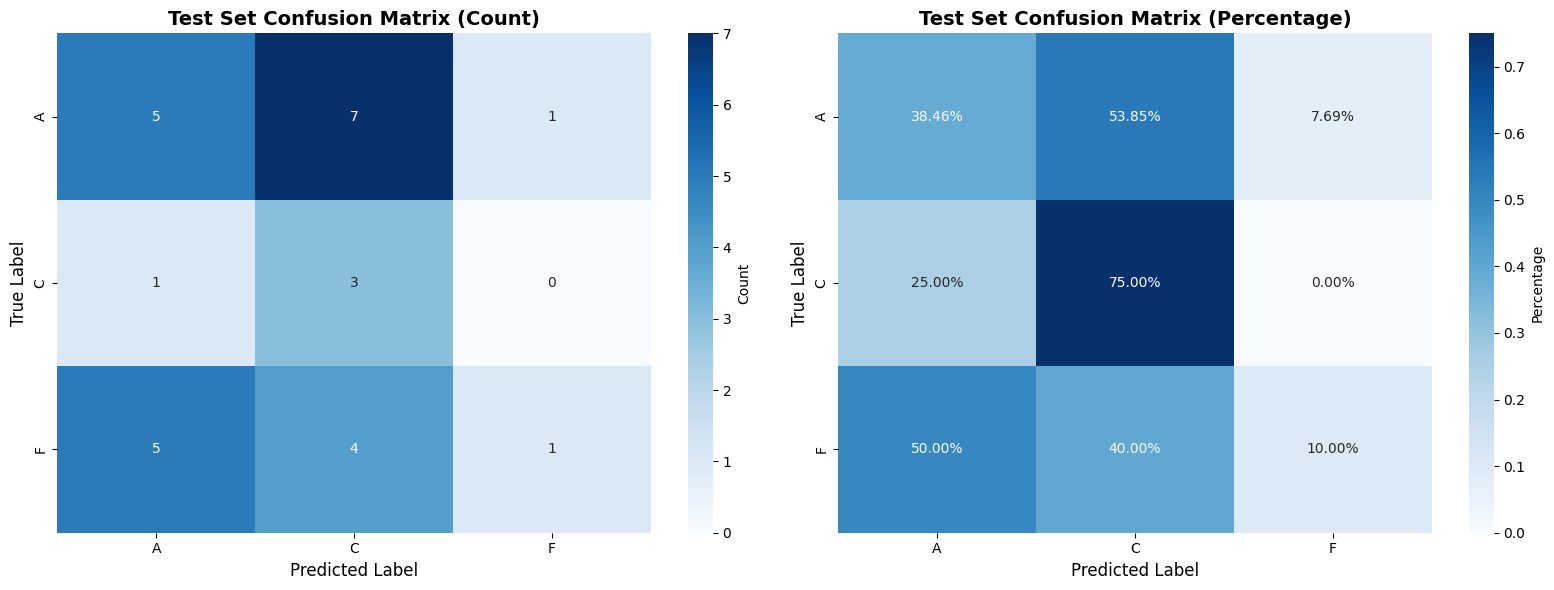

In [13]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

# The features are 'stationary_ratio' and 'Tik-norm'
X = data[list(features.keys())]

# The target is 'Group'
y = data['Group']

# Split the data into train+validation set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the train data into train set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_val_int = le.transform(y_val)
y_test_int = le.transform(y_test)

clf = SVC(probability=True, kernel='linear', random_state=42) # You can change the kernel as needed
clf.fit(X_train_scaled, y_train_int)

# Validate and test metrics
for label, group_name in enumerate(le.classes_):
    y_val_label = (y_val_int == label).astype(int)
    y_test_label = (y_test_int == label).astype(int)
    y_val_pred_prob = clf.predict_proba(X_val_scaled)[:, label]
    y_test_pred_prob = clf.predict_proba(X_test_scaled)[:, label]

    fpr_val, tpr_val, _ = roc_curve(y_val_label, y_val_pred_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test_label, y_test_pred_prob)

    print(f"Validation ROC AUC for class {group_name} (Class {label}): {auc(fpr_val, tpr_val)}")
    print(f"Test ROC AUC for class {group_name} (Class {label}): {auc(fpr_test, tpr_test)}")

y_val_pred = le.inverse_transform(clf.predict(X_val_scaled))
y_test_pred = le.inverse_transform(clf.predict(X_test_scaled))

print("\nValidation Precision, Recall, F1-score:\n", classification_report(y_val, y_val_pred))
print("\nTest Precision, Recall, F1-score:\n", classification_report(y_test, y_test_pred))

# 繪製 Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score
from datetime import datetime

# 創建結果目錄
results_dir = './baseline_results/SVM'
os.makedirs(results_dir, exist_ok=True)

# 計算評估指標
y_val_pred_int = clf.predict(X_val_scaled)
y_test_pred_int = clf.predict(X_test_scaled)
y_val_pred_proba = clf.predict_proba(X_val_scaled)
y_test_pred_proba = clf.predict_proba(X_test_scaled)

val_balanced_acc = balanced_accuracy_score(y_val_int, y_val_pred_int)
test_balanced_acc = balanced_accuracy_score(y_test_int, y_test_pred_int)

macro_roc_auc_val = roc_auc_score(y_val_int, y_val_pred_proba, multi_class='ovr', average='macro')
weighted_roc_auc_val = roc_auc_score(y_val_int, y_val_pred_proba, multi_class='ovr', average='weighted')
macro_roc_auc_test = roc_auc_score(y_test_int, y_test_pred_proba, multi_class='ovr', average='macro')
weighted_roc_auc_test = roc_auc_score(y_test_int, y_test_pred_proba, multi_class='ovr', average='weighted')

overfitting_gap = val_balanced_acc - test_balanced_acc

# 保存評估指標到文本文件
with open(os.path.join(results_dir, 'evaluation_metrics.txt'), 'w', encoding='utf-8') as f:
    f.write("="*60 + "\n")
    f.write("多分類評估結果\n")
    f.write("="*60 + "\n")
    f.write(f"生成時間: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("驗證集結果:\n")
    f.write("-"*60 + "\n")
    f.write(f"Balanced Accuracy: {val_balanced_acc:.4f}\n")
    f.write(f"宏平均 ROC AUC: {macro_roc_auc_val:.4f}\n")
    f.write(f"加權平均 ROC AUC: {weighted_roc_auc_val:.4f}\n\n")
    f.write("混淆矩陣:\n")
    f.write(str(confusion_matrix(y_val_int, y_val_pred_int)) + "\n\n")
    f.write("分類報告:\n")
    f.write(classification_report(y_val_int, y_val_pred_int, 
                                target_names=list(le.classes_)) + "\n")
    
    f.write("\n" + "="*60 + "\n")
    f.write("測試集結果:\n")
    f.write("-"*60 + "\n")
    f.write(f"Balanced Accuracy: {test_balanced_acc:.4f}\n")
    f.write(f"宏平均 ROC AUC: {macro_roc_auc_test:.4f}\n")
    f.write(f"加權平均 ROC AUC: {weighted_roc_auc_test:.4f}\n\n")
    f.write("混淆矩陣:\n")
    f.write(str(confusion_matrix(y_test_int, y_test_pred_int)) + "\n\n")
    f.write("分類報告:\n")
    f.write(classification_report(y_test_int, y_test_pred_int,
                                target_names=list(le.classes_)) + "\n")
    
    f.write("\n" + "="*60 + "\n")
    f.write("過擬合分析:\n")
    f.write("-"*60 + "\n")
    f.write(f"驗證集 Balanced Accuracy: {val_balanced_acc:.4f}\n")
    f.write(f"測試集 Balanced Accuracy: {test_balanced_acc:.4f}\n")
    f.write(f"過擬合差距: {overfitting_gap:.4f}\n")

print(f"✓ 評估指標已保存到: {os.path.join(results_dir, 'evaluation_metrics.txt')}")

class_names = list(le.classes_)

# 驗證集 Confusion Matrix
cm_val = confusion_matrix(y_val_int, y_val_pred_int)
cm_val_normalized = cm_val.astype('float') / (cm_val.sum(axis=1)[:, np.newaxis] + 1e-10)
cm_val_normalized = np.nan_to_num(cm_val_normalized)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 原始混淆矩陣
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names,
           ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Validation Set Confusion Matrix (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# 歸一化混淆矩陣
sns.heatmap(cm_val_normalized, annot=True, fmt='.2%', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names,
           ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Validation Set Confusion Matrix (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
val_cm_path = os.path.join(results_dir, 'confusion_matrix_validation.png')
plt.savefig(val_cm_path, dpi=300, bbox_inches='tight')
print(f"✓ 驗證集混淆矩陣已保存到: {val_cm_path}")
plt.show()
plt.close()

# 測試集 Confusion Matrix
cm_test = confusion_matrix(y_test_int, y_test_pred_int)
cm_test_normalized = cm_test.astype('float') / (cm_test.sum(axis=1)[:, np.newaxis] + 1e-10)
cm_test_normalized = np.nan_to_num(cm_test_normalized)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 原始混淆矩陣
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names,
           ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Test Set Confusion Matrix (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# 歸一化混淆矩陣
sns.heatmap(cm_test_normalized, annot=True, fmt='.2%', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names,
           ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Test Set Confusion Matrix (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
test_cm_path = os.path.join(results_dir, 'confusion_matrix_test.png')
plt.savefig(test_cm_path, dpi=300, bbox_inches='tight')
print(f"✓ 測試集混淆矩陣已保存到: {test_cm_path}")
plt.show()
plt.close()
